# Exercise 5: Random Forests

**Note**: Please insert the names of all participating students:

1.
2.
3.
4.
5.

In [1]:
# import sys, os
# if 'google.colab' in sys.modules:
#   if os.getcwd() == '/content':
#     !git clone 'https://github.com/inb-luebeck/cs5450.git'
#     os.chdir('cs5450')

In this exercise, we will use the random forest algorithm to combine multiple decision trees to one strong classifier for a multi-class classification problem on a two-dimensional dataset. The individual trees of the random forest differ because they are trained with a random subset of (i) features — in this exercise a single feature of the two-dimensional dataset
— and (ii) training data. The latter is done by applying the technique of *bootstrap aggregating (bagging)*. Given a dataset $D$ of size n, bagging generates m new training sets $D_i$ , each of size n, by sampling from $D$ uniformly and with replacement. Note
that by sampling with replacement, some observations may be repeated in $D_i$ and some observations are not used at all. They are called *out-of-bag (oob) observations* and can
be used for testing.

We will build on the code which we have provided here. You only need to write code at the places indicated by TODO in the files.
Implement the missing parts in this file. When done correctly, your code should do the following:

1. Create a random dataset.

2. Iterativly, do the following:
    - Randomly select a single feature.
    - Randomly generate a bootstrapped training set.
    - Train a decision tree on the bootstrapped set with a single feature
    - Generate a test set using the out-of-bag samples.
    - Compute the posterior probabilities of the test set.
    - Combine the out-of-bag posterior probabilities over the forest to obtain a prediction for each sample of the complete dataset.
    - Calculate the out-of-bag error of the random forest.
    - Visualize the data and the decision boundaries of the random forest.

3. Plot the out-of-bag error of the random forest for each iteration.

4. Good initial values are: `n_samples=500`, `n_classes=5`, `n_trees=100`, `n_splits=4`, `seed=20`.

You can visualize a decision tree with the function `some_tree.plot_tree`

Helpful Documentation:
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [python sets](https://docs.python.org/2/library/sets.html)
- [random integers](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.randint.html)

In [2]:
import numpy as np
import random
from sklearn import tree as scikit_tree
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation


In [3]:
#######################################################
#################### DATA #############################
#######################################################

def gen_data(n_samples, n_classes):
    """
     GENDATA Generate data and its labels.

     INPUT:
       n_samples : number of samples (observations)
       n_classes : number of distinct classes

     OUTPUT:
       data : two-dimensional data points
       labels : multi-class labels (i.e. 1, 2, 3, ...) of the data points
    """

    center = np.random.rand(n_classes, 2)
    data = np.random.rand(n_samples, 2)
    labels = np.ones(n_samples)
    n_samples_per_class = int(n_samples / n_classes)

    for i in range(n_classes):
        r = np.random.randn(n_samples_per_class, 2) / 12.
        b = i * n_samples_per_class
        e = (i+1)*n_samples_per_class
        data[b:e, :] = center[i, :] + r
        labels[b:e] = i

    return data, labels

In [4]:
#######################################################
################ VISUALIZATION ########################
#######################################################

def get_decision_boundary(data, labels, trees_):
    xrange = [data[:,0].min(), data[:,0].max()]
    yrange = [data[:,1].min(), data[:,1].max()]
    inc = 0.01;
    x, y = np.meshgrid(np.arange(xrange[0], xrange[1],inc), np.arange(yrange[0], yrange[1],inc));
    image_shape = x.shape;
    xy = np.stack([x.flatten(), y.flatten()],-1);

    n_samples = x.size #numel(x);
    n_classes = (np.unique(labels)).shape[0];

    predictions = np.zeros((n_samples, n_classes))
    for tree in trees_:
        random_feature = tree.feature
        s = tree.predict_proba(xy[:, random_feature])
        predictions = predictions + s;

    predictions = predictions / float(len(trees_));
    c = predictions.argmax(1)
    a = predictions.max(1).reshape(image_shape)

    c = c.reshape(image_shape)
    return c

class Animation(object):
    """
    Creates animation object to visualize the decision boundaries of the strong classifier.
    """
    def __init__(self, data, labels, decision_boundaries):
        """
        INPUT:
            data : 2D data points
            labels : ndarray of class labels with integer values -1 or 1
            decision_boundaries: ndarray of shape (n_classifiers, n**2) with prediction results for an (n x n) grid.
        """
        super().__init__()
        self.decision_boundaries = decision_boundaries

        fig, ax = plt.subplots(figsize=(12, 8))


        xrange = [data[:,0].min(), data[:,0].max()]
        yrange = [data[:,1].min(), data[:,1].max()]
        cmap = plt.cm.get_cmap('jet',lut=n_classes)

        for i in range(n_classes):
            tmp = data[labels==i,:]
            plt.scatter(*tmp.T, marker='d',color=cmap(i), s=150, edgecolor='k')

        im = ax.imshow(decision_boundaries[0], extent=xrange + yrange,
                       interpolation='none', cmap='jet', origin='lower',
                       vmin=0, vmax=n_classes-1,
                       alpha=.7)

        self.fig = fig
        self.im = im

    def animate(self, i):
        """
        animate function for FuncAnimation

        Input:
            i : integer for indexing
        """
        self.im.set_array(self.decision_boundaries[i])

    def get_animation(self):
        """
        Return animation object which holds the animation
        """
        return FuncAnimation(self.fig, self.animate, frames=len(self.decision_boundaries))


In [5]:
#######################################################
################ CLASSIFIER ###########################
#######################################################

class MyTree():
    def __init__(self, tree, feature):
        self.clf = tree
        self.feature = feature

    def predict_proba(self, x):
        assert x.ndim == 1
        x = x.reshape(x.shape[0], 1)
        return self.clf.predict_proba(x)

    def predict(self, x):
        return self.clf.predict(x)

    def plot_tree(self):
        scikit_tree.plot_tree(self.clf)

def train_tree(data, labels, feature, n_splits):
    """
     TRAINTREE Train a single decision tree.

     INPUT:
       data : one-dimensional data points
       labels : multi-class labels of the data points
       feature : the randomly selected feature (i.e. 1 or 2)
       n_splits : maximum depth

     OUTPUT:
       tree : trained decision tree
    """
    assert data.ndim == 1,'After random feature selection, trainData must be single-column'
    data = data.reshape((data.shape[0], 1))

    tree = scikit_tree.DecisionTreeClassifier(max_depth=n_splits, criterion='entropy')
    tree = tree.fit(data, labels)

    return MyTree(tree, feature)
#tree = fitctree(data, labels, 'MaxNumSplits', nSplits, 'SplitCriterion', 'deviance', 'PredictorNames', int2str(feature));

In [6]:
## Define variables

# TODO nSamples : number of samples (observations)
n_samples = 500;

# TODO nClasses : number of classes
n_classes = 5;

# TODO nTrees : number of trees
n_trees = 100;

# TODO nSplits : maximum number of decision splits of the tree
n_splits = 3;

# TODO seed : set seed for reproducable results
seed = 20;

#rng(seed);
random.seed(seed)
np.random.seed(seed)

In [27]:
## Train, combine, and visualize multiple decision trees

# TODO generate data (help genData)
data, labels = gen_data(n_samples=n_samples, n_classes=n_classes)

trees_ = list()
posterior = np.zeros((n_samples, n_trees, n_classes))
errors = list()
decision_boundaries = []

# loop number of trees
for t in range(n_trees):

    # TODO select a random feature (i.e. 1 or 2) of the two-dimensional dataset
    feature = np.random.randint(0,2)

    # TODO randomly sample 'n_samples' data points and its labels with replacement
    # This is called bootstrap aggregating (bagging)
    train_idx = np.random.randint(0,high=n_samples, size=n_samples)
    train_data = data[train_idx, feature]
    train_labels = labels[train_idx]

    # TODO train the decision tree (train_tree)
    trees_.append(
        train_tree(train_data, train_labels, feature, n_splits)
    )

    # TODO use the remaining samples to test the tree (set difference)
    # These are called out-of-bag (oob) observations
    all_idx = set(range(n_samples))
    test_idx = list(all_idx - set(train_idx))
    # print(test_idx)
    test_data = data[test_idx, feature]
    test_labels = labels[test_idx]

    # TODO compute the oob posterior probabilities
    # (see MyTree & scikit DecisionTreeClassifier)
    scores = trees_[-1].predict_proba(test_data)
    posterior[test_idx,t,:] = scores

    # TODO compute the class predictions of the random forest (so far)
    predictions = np.argmax(posterior, axis=2)
    print(predictions)

#     # TODO compute the oob error of the random forest (so far)
#     errors.append(
#         -1
#     )

#     # TODO visualize the data and the current decision boundaries (help showData)
#     #show_data(data, labels, trees_);
#     decision_boundaries.append(-1)


# # TODO plot the oob error of the random forest for each iteration
# plt.figure()
# plt.plot(errors);

[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]
 ...
 [0 0 4 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]
 ...
 [0 0 4 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]
 ...
 [0 0 4 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]
 ...
 [0 0 4 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]
 ...
 [0 0 4 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]
 ...
 [0 0 4 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [

/tmp/ipykernel_9319/179330167.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet',lut=n_classes)


IndexError: list index out of range

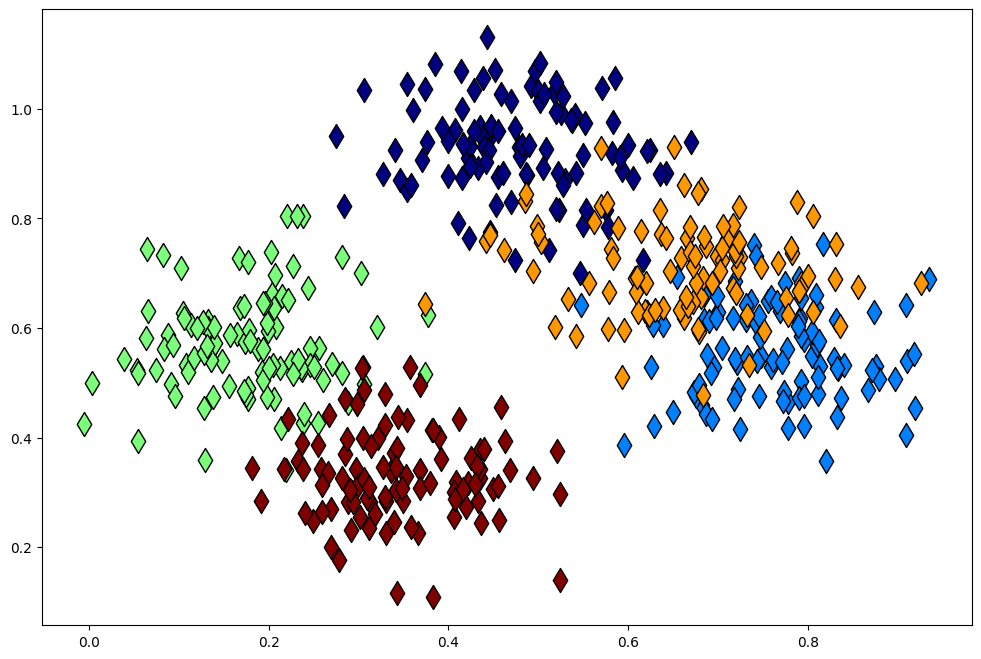

In [13]:
animation = Animation(data, labels, decision_boundaries)
HTML(animation.get_animation().to_jshtml())

In [ ]:
# TODO: plot one of the trees
plt.figure(figsize=(20,20))

1. Unlike a SVM, a decision tree is intrinsically suited for a multi-class problem.

correct

2. A decision tree cannot be used for regression.

[Your answer]

3. Pure nodes of a decision tree (i.e. only a single class is present) have a high entropy.

wrong

4. A decision stump (a one-level decision tree) is prone to overfitting.

correct

5. Pruning a decision tree can be useful to avoid overfitting.

correct

6. Each decision tree in a random forest is identical.

wrong

7. The expected fraction of unique observations in a bootstrap dataset is approximately $63.2 \%$.

[Your answer]

8. The out-of-bag error estimates the generalization error of the random forest.

correct

9. A random forest can be both trained and tested in parallel.

correct